In [1]:
from IPython.core.debugger import set_trace

%load_ext nb_black
%matplotlib inline

# import pandas as pd
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from pathlib import Path


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

np.random.seed(42)
tf.random.set_seed(42)

plt.style.use(style="seaborn")
plt.rcParams['figure.dpi'] = 400
sns.set_style('whitegrid')



/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


<IPython.core.display.Javascript object>

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


<IPython.core.display.Javascript object>

In [3]:
!nvidia-smi

Sat Jul  9 06:12:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   56C    P8    19W / 200W |   2628MiB /  4096MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<IPython.core.display.Javascript object>

In [4]:
csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AAPL/AAPL_WITH_TWINT_FINBERT_SA.csv"

<IPython.core.display.Javascript object>

In [5]:
df = pd.read_csv(csv_path)
df.sort_values(by=["date"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
# Slice [start:stop:step], starting from index 5 take every 6th record.
# df = df[5::6]

date_time = pd.to_datetime(df.pop('date'))
# title = df.pop('tweet')

df = df[["5. adjusted close", "2. high", "3. low", "6. volume"]]  

df.index = date_time

<IPython.core.display.Javascript object>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3064 entries, 2010-01-04 to 2022-03-04
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   5. adjusted close  3064 non-null   float64
 1   2. high            3064 non-null   float64
 2   3. low             3064 non-null   float64
 3   6. volume          3064 non-null   float64
dtypes: float64(4)
memory usage: 119.7 KB


<IPython.core.display.Javascript object>

In [7]:
#df.set_index("date", drop=True, inplace=True)
df.head()

,5. adjusted close,2. high,3. low,6. volume
date,,,,
2010-01-04,6.543876,214.50,212.38,17633200.0
2010-01-05,6.555190,215.59,213.25,21496600.0
2010-01-06,6.450921,215.23,210.75,19720000.0
2010-01-07,6.438996,212.00,209.05,17040400.0
2010-01-08,6.481804,212.00,209.06,15986100.0


<IPython.core.display.Javascript object>

We'll use only the close feature.

In [8]:
# df = df[["close"]]

<IPython.core.display.Javascript object>

In [9]:
type(df["5. adjusted close"]) == type(df[["5. adjusted close"]])

False

<IPython.core.display.Javascript object>

In [10]:
type(df[["5. adjusted close"]])

pandas.core.frame.DataFrame

<IPython.core.display.Javascript object>

In [11]:
df.describe()

,5. adjusted close,2. high,3. low,6. volume
count,3064.000000,3064.000000,3064.000000,3.064000e+03
mean,42.736360,262.829696,257.667717,3.829313e+07
std,41.154337,161.044982,157.946296,3.233265e+07
min,5.872396,90.700000,89.470000,5.624800e+06
25%,16.285903,129.535000,127.102500,1.762402e+07
50%,26.270965,194.330000,190.875000,2.763896e+07
75%,48.589739,369.210000,358.682500,4.667886e+07
max,181.778019,705.070000,699.570000,3.326072e+08


<IPython.core.display.Javascript object>

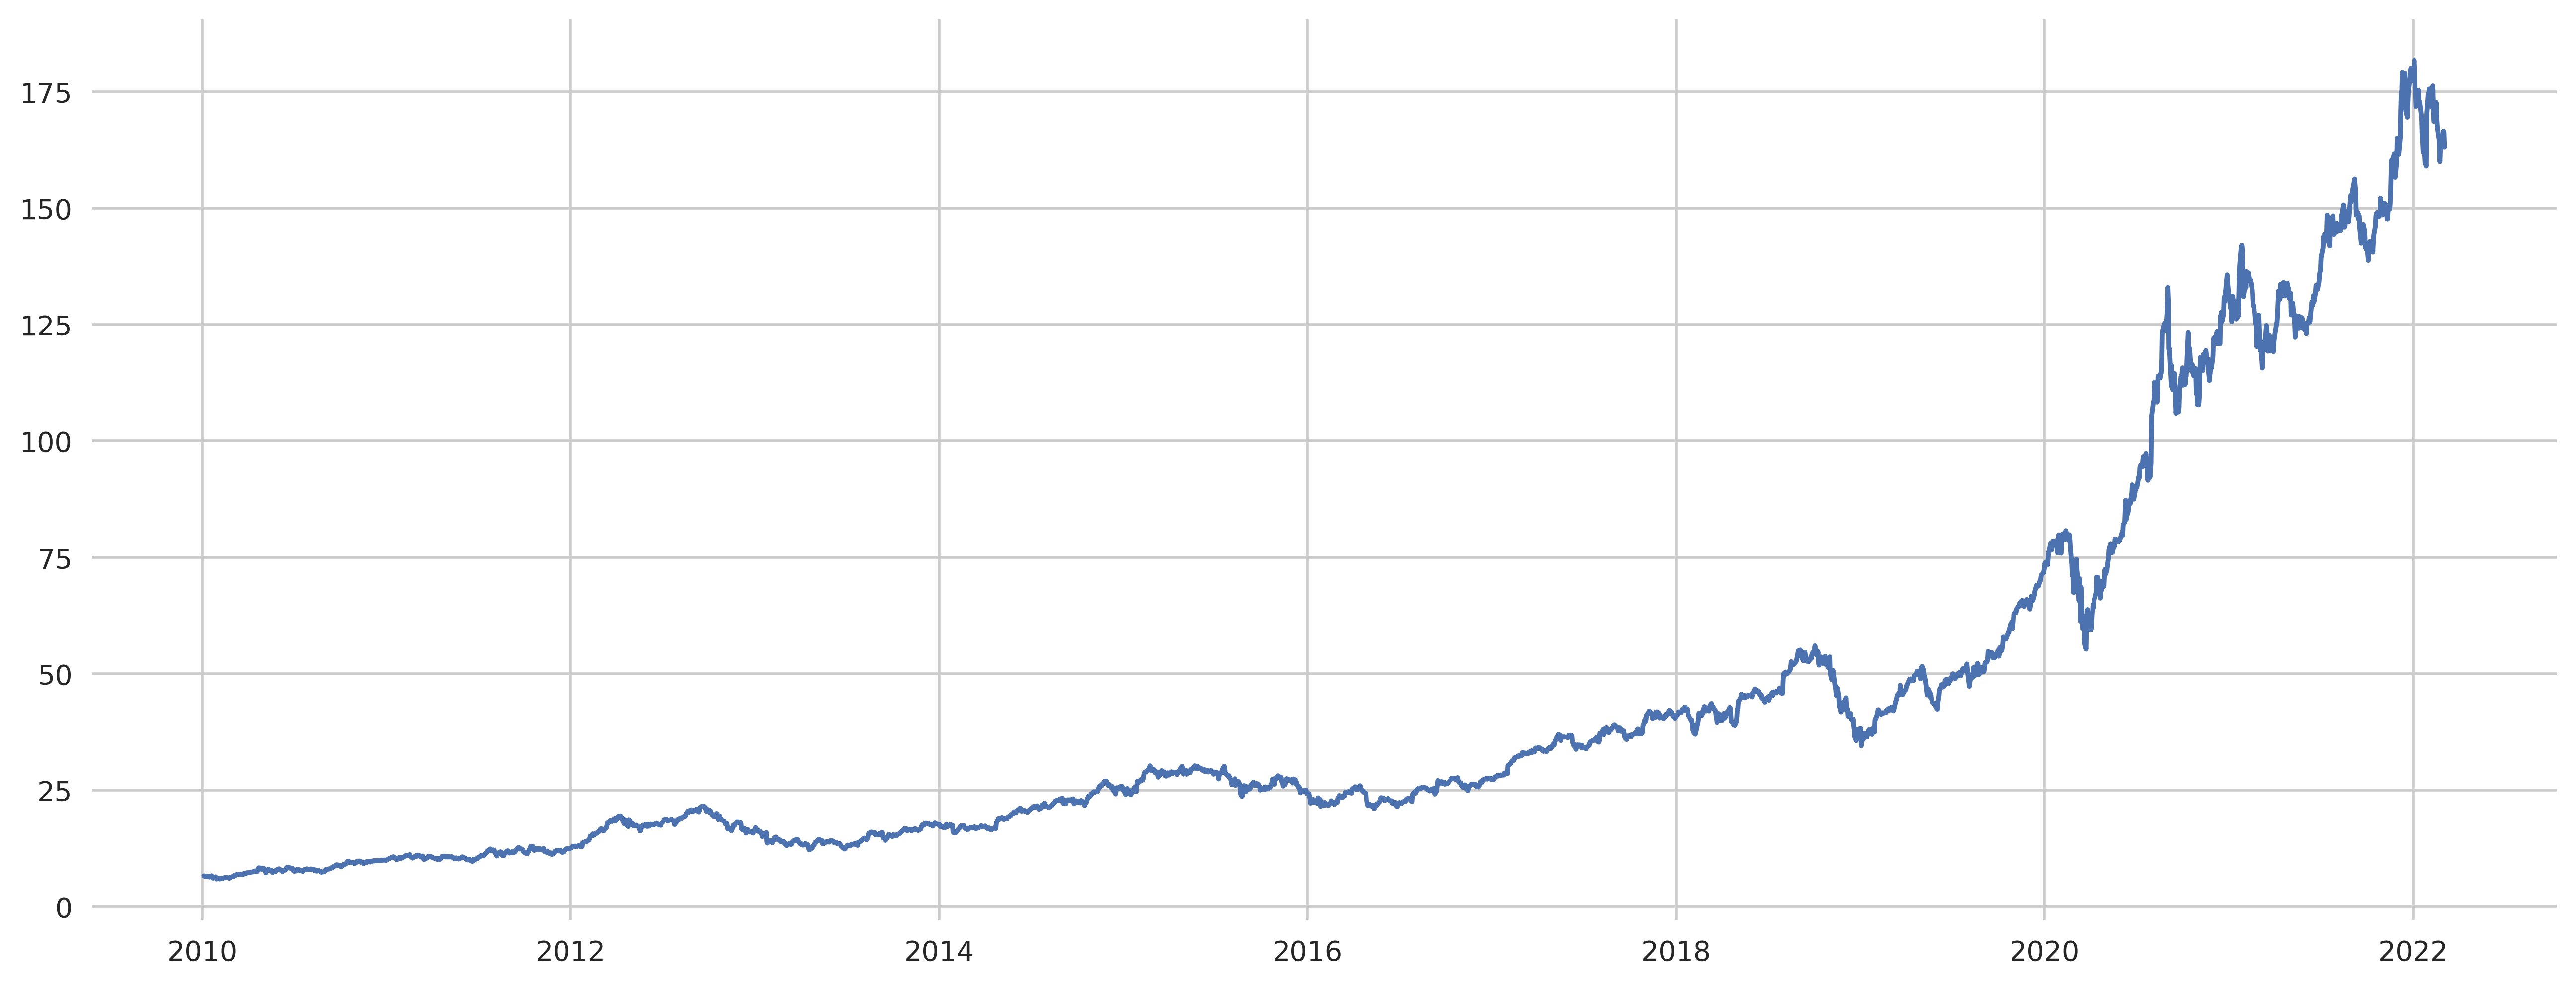

<IPython.core.display.Javascript object>

In [12]:
plt.figure(1, figsize=(16, 6))
_ = plt.plot(df['5. adjusted close'])

Calculate the percentage change.

The reason for using pct_change instead of the prices is the benefit of normalization as we can measure all variables in a comparable metric. Also returns have more manageable statistical properties than prices such as stationarity, as in most cases we don't have stationary prices but we can have stationary returns.

A stationary time series is one where statistical properties such as mean, variance, correlation, etc are constant over time.
For more details on stationarity: https://en.wikipedia.org/wiki/Stationary_process

In [13]:
df["returns"] = df['5. adjusted close'].pct_change()

<IPython.core.display.Javascript object>

In [14]:
df.head(5)

,5. adjusted close,2. high,3. low,6. volume,returns
date,,,,,
2010-01-04,6.543876,214.50,212.38,17633200.0,NaN
2010-01-05,6.555190,215.59,213.25,21496600.0,0.001729
2010-01-06,6.450921,215.23,210.75,19720000.0,-0.015906
2010-01-07,6.438996,212.00,209.05,17040400.0,-0.001849
2010-01-08,6.481804,212.00,209.06,15986100.0,0.006648


<IPython.core.display.Javascript object>

Calculate the log returns.

Why use log returns: https://quantivity.wordpress.com/2011/02/21/why-log-returns/

In [15]:
df["log_returns"] = np.log(1 + df["returns"])

<IPython.core.display.Javascript object>

In [16]:
df.head(5)

,5. adjusted close,2. high,3. low,6. volume,returns,log_returns
date,,,,,,
2010-01-04,6.543876,214.50,212.38,17633200.0,NaN,NaN
2010-01-05,6.555190,215.59,213.25,21496600.0,0.001729,0.001727
2010-01-06,6.450921,215.23,210.75,19720000.0,-0.015906,-0.016034
2010-01-07,6.438996,212.00,209.05,17040400.0,-0.001849,-0.001850
2010-01-08,6.481804,212.00,209.06,15986100.0,0.006648,0.006626


<IPython.core.display.Javascript object>

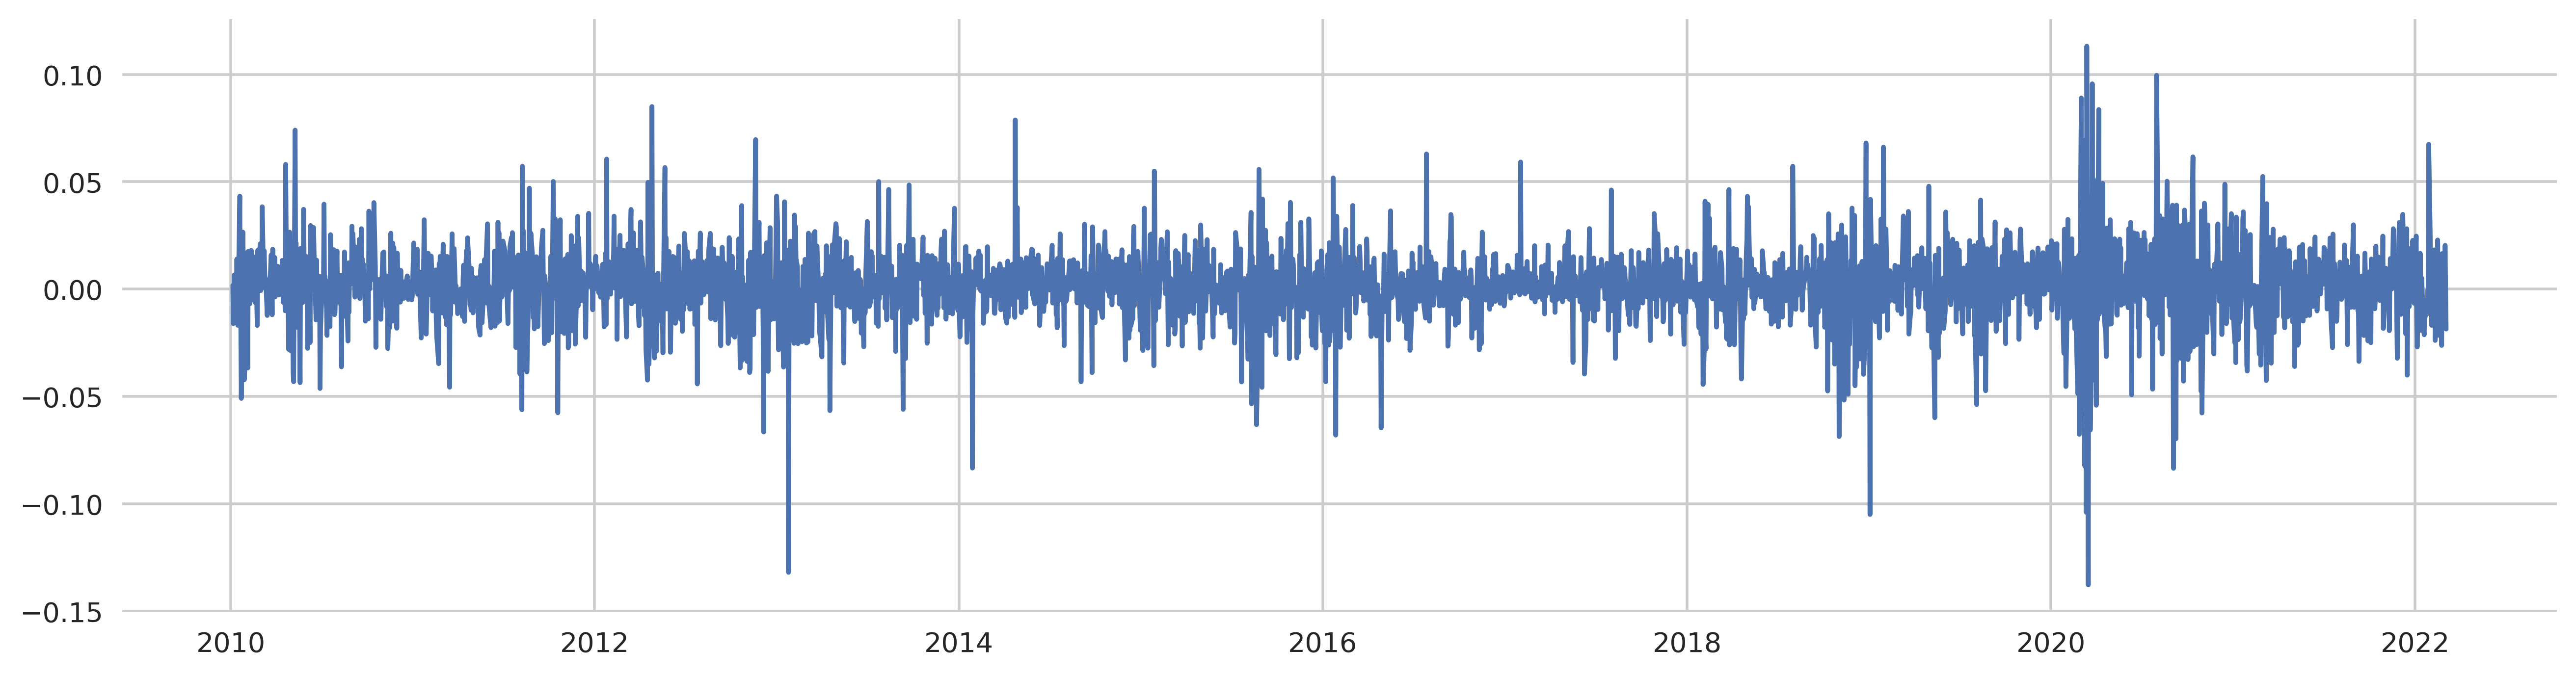

<IPython.core.display.Javascript object>

In [17]:
plt.figure(1, figsize=(16, 4))
plt.plot(df.log_returns)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3064 entries, 2010-01-04 to 2022-03-04
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   5. adjusted close  3064 non-null   float64
 1   2. high            3064 non-null   float64
 2   3. low             3064 non-null   float64
 3   6. volume          3064 non-null   float64
 4   returns            3063 non-null   float64
 5   log_returns        3063 non-null   float64
dtypes: float64(6)
memory usage: 167.6 KB


<IPython.core.display.Javascript object>

In [19]:
X = df[["5. adjusted close", "2. high", "3. low", "6. volume"]].values


# df.dropna(inplace=True)
# X = df[["5. adjusted close", "log_returns"]].values


# X = df[["5. adjusted close", "2. high", "3. low", "6. volume", "log_returns"]].values

<IPython.core.display.Javascript object>

In [20]:
from sklearn.preprocessing import MinMaxScaler

<IPython.core.display.Javascript object>

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaler.transform(X)

<IPython.core.display.Javascript object>

In [22]:
y = [x[0] for x in X_scaled]

<IPython.core.display.Javascript object>

#### Train test split

In [23]:
split = int(len(X_scaled) * 0.9)
print(split)

2757


<IPython.core.display.Javascript object>

In [24]:
X_train = X_scaled[:split]
X_test = X_scaled[split : len(X_scaled)]
y_train = y[:split]
y_test = y[split : len(y)]

<IPython.core.display.Javascript object>

In [25]:
print(len(X_train))
print(len(X_test))

2757
307


<IPython.core.display.Javascript object>

In [26]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

<IPython.core.display.Javascript object>

#### Labeling

We want to predict the stock price at a future time. We'll predict the stock price at time t + 1 relative to the stock price at time t.

As we're going to use an LSTM architecture, we know that it has memory and that it is maintained by setting the time step, basically how many steps in the past we want the LSTM to use.

The time step  refers to how many steps in time we want the backpropagation algorithm to use when calculating gradients for weight updates during training.

So we can use a method to create both the timestep and the output variable, the t + 1.

In [27]:
n = 63
Xtrain = []
ytrain = []
Xtest = []
ytest = []
for i in range(n, len(X_train)):
    Xtrain.append(X_train[i - n : i, : X_train.shape[1]])
    ytrain.append(y_train[i])  # predict next record
for i in range(n, len(X_test)):
    Xtest.append(X_test[i - n : i, : X_test.shape[1]])
    ytest.append(y_test[i])  # predict next record

<IPython.core.display.Javascript object>

In [28]:
df.head(5)

,5. adjusted close,2. high,3. low,6. volume,returns,log_returns
date,,,,,,
2010-01-04,6.543876,214.50,212.38,17633200.0,NaN,NaN
2010-01-05,6.555190,215.59,213.25,21496600.0,0.001729,0.001727
2010-01-06,6.450921,215.23,210.75,19720000.0,-0.015906,-0.016034
2010-01-07,6.438996,212.00,209.05,17040400.0,-0.001849,-0.001850
2010-01-08,6.481804,212.00,209.06,15986100.0,0.006648,0.006626


<IPython.core.display.Javascript object>

In [29]:
val = np.array(ytrain[0])
val = np.c_[val, np.zeros(val.shape), np.zeros(val.shape), np.zeros(val.shape)]

<IPython.core.display.Javascript object>

In [30]:
scaler.inverse_transform(val)

array([[7.32451811e+00, 9.07000000e+01, 8.94700000e+01, 5.62480000e+06]])

<IPython.core.display.Javascript object>

In an LSTM network the input for each LSTM layer needs to contain the following information:
- The number of observations
- The time steps
- The features

Therefore we need to add a temporal dimension compared to a classical network:

(number of observations, number of steps, number of features per step)

In [31]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

<IPython.core.display.Javascript object>

In [32]:
print(Xtrain.shape)
print(ytrain.shape)
print("---")
print(Xtest.shape)
print(ytest.shape)

(2694, 63, 4)
(2694,)
---
(244, 63, 4)
(244,)


<IPython.core.display.Javascript object>

#### LSTM Model

In [33]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

<IPython.core.display.Javascript object>

In [34]:
results_path = Path('results', 'lstm')
if not results_path.exists():
    results_path.mkdir(parents=True)

<IPython.core.display.Javascript object>

In [35]:
MAX_EPOCHS = 500
# MAX_EPOCHS = 100
patience=50
# patience=30

lstm_path = (results_path / 'lstm.h5').as_posix()
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,
                                     # learning_rate=lr_schedule,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

def compile_and_fit(model, patience=patience):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',  
                                                    restore_best_weights=True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.losses.MeanAbsoluteError()])

  history = model.fit(Xtrain, ytrain, epochs=MAX_EPOCHS,
                      validation_data=(Xtest, ytest),
                      callbacks=[early_stopping, checkpointer],
                      batch_size=32,
                      shuffle=True,
                      verbose=1)
  return history


<IPython.core.display.Javascript object>

In [36]:
from keras.layers import Dropout

<IPython.core.display.Javascript object>

In [37]:
model = Sequential([
    LSTM(units=64, 
         return_sequences=False,
         # Shape => [batch, time, features]
         input_shape=(Xtrain.shape[1], Xtrain.shape[2]), 
         name='LSTM'),
    # Dropout(0.10),
    Dense(1, name='Output')
])

<IPython.core.display.Javascript object>

In [38]:
history = compile_and_fit(model)


Epoch 1/500
85/85 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0275
Epoch 1: val_loss improved from inf to 0.00173, saving model to results/lstm/lstm.h5
85/85 [==============================] - 4s 21ms/step - loss: 0.0020 - mean_absolute_error: 0.0275 - val_loss: 0.0017 - val_mean_absolute_error: 0.0342
Epoch 2/500
85/85 [==============================] - ETA: 0s - loss: 5.2322e-04 - mean_absolute_error: 0.0163
Epoch 2: val_loss did not improve from 0.00173
85/85 [==============================] - 1s 14ms/step - loss: 5.2322e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0020 - val_mean_absolute_error: 0.0393
Epoch 3/500
83/85 [============================>.] - ETA: 0s - loss: 3.3372e-04 - mean_absolute_error: 0.0125
Epoch 3: val_loss improved from 0.00173 to 0.00107, saving model to results/lstm/lstm.h5
85/85 [==============================] - 1s 17ms/step - loss: 3.3220e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0011 - val_mean_absolute_err

<IPython.core.display.Javascript object>

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 64)                17664     
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [40]:
train_predict_scaled = model.predict(Xtrain).squeeze()
test_predict_scaled = model.predict(Xtest).squeeze()

print(len(train_predict_scaled))
print(len(test_predict_scaled))

2694
244


<IPython.core.display.Javascript object>

In [41]:
model.evaluate(Xtrain, ytrain)

85/85 [==============================] - 1s 8ms/step - loss: 7.6860e-05 - mean_absolute_error: 0.0073


[7.686017488595098e-05, 0.00729383435100317]

<IPython.core.display.Javascript object>

In [42]:
model.evaluate(Xtest, ytest)

8/8 [==============================] - 0s 7ms/step - loss: 1.8758e-04 - mean_absolute_error: 0.0105


[0.00018757965881377459, 0.010536035522818565]

<IPython.core.display.Javascript object>

In [43]:
from sklearn.metrics import mean_absolute_error

<IPython.core.display.Javascript object>

In [44]:
# calculate mean absolute error
trainScore = mean_absolute_error(ytrain, train_predict_scaled)
print("Train Score: %.4f MAE" % (trainScore))

testScore = mean_absolute_error(ytest, test_predict_scaled)
print("Test Score: %.4f MAE" % (testScore))

Train Score: 0.0073 MAE
Test Score: 0.0103 MAE


<IPython.core.display.Javascript object>

In [45]:
_ = np.array(train_predict_scaled)
_ = np.c_[_, np.zeros(_.shape[0]), np.zeros(_.shape[0]), np.zeros(_.shape[0])]

<IPython.core.display.Javascript object>

In [46]:
_train_predict_scaled = scaler.inverse_transform(_)

<IPython.core.display.Javascript object>

In [47]:
_train_predict_scaled[0][0]

6.2432219837039264

<IPython.core.display.Javascript object>

In [48]:
train_predict_rescaled = np.zeros([2694,], dtype='float32')

<IPython.core.display.Javascript object>

In [49]:
for i, x in enumerate(_train_predict_scaled):
    train_predict_rescaled[i] = x[0]

<IPython.core.display.Javascript object>

In [50]:
train_predict_rescaled = pd.Series(train_predict_rescaled, index=df.iloc[63:split].index)


<IPython.core.display.Javascript object>

In [51]:
_ = np.array(test_predict_scaled)
_ = np.c_[_, np.zeros(_.shape[0]), np.zeros(_.shape[0]), np.zeros(_.shape[0])]

<IPython.core.display.Javascript object>

In [52]:
_test_predict_scaled = scaler.inverse_transform(_)

<IPython.core.display.Javascript object>

In [53]:
_test_predict_scaled[0][0]

123.14086476402568

<IPython.core.display.Javascript object>

In [54]:
test_predict_rescaled = np.zeros([244,], dtype='float32')

<IPython.core.display.Javascript object>

In [55]:
for i, x in enumerate(_test_predict_scaled):
    test_predict_rescaled[i] = x[0]

<IPython.core.display.Javascript object>

In [56]:
test_predict_rescaled = pd.Series(test_predict_rescaled, index=df.iloc[split+63:].index)

<IPython.core.display.Javascript object>

In [57]:
df_compare = df.iloc[-244:].copy()

<IPython.core.display.Javascript object>

In [58]:
df_compare["preds"] = test_predict_rescaled

<IPython.core.display.Javascript object>

In [59]:
df_compare

,5. adjusted close,2. high,3. low,6. volume,returns,log_returns,preds
date,,,,,,,
2021-03-18,119.818452,123.18,120.320,121469755.0,-0.033905,-0.034493,123.140862
2021-03-19,119.281640,121.43,119.675,185549522.0,-0.004480,-0.004490,119.387184
2021-03-22,122.661568,123.87,120.260,111912284.0,0.028336,0.027942,118.616837
2021-03-23,121.816586,124.24,122.140,95467142.0,-0.006889,-0.006913,122.198586
2021-03-24,119.381049,122.90,120.065,88530485.0,-0.019993,-0.020196,122.637520
...,...,...,...,...,...,...,...
2022-02-28,165.120000,165.42,162.430,95056629.0,0.001638,0.001637,165.258850
2022-03-01,163.200000,166.60,161.970,83474425.0,-0.011628,-0.011696,165.705261
2022-03-02,166.560000,167.36,162.950,79724750.0,0.020588,0.020379,163.857574


<IPython.core.display.Javascript object>

In [60]:
testScore = mean_absolute_error(df_compare["5. adjusted close"].values, df_compare["preds"].values)
print("Test Score: %.4f MAE" % (testScore))

Test Score: 1.8178 MAE


<IPython.core.display.Javascript object>

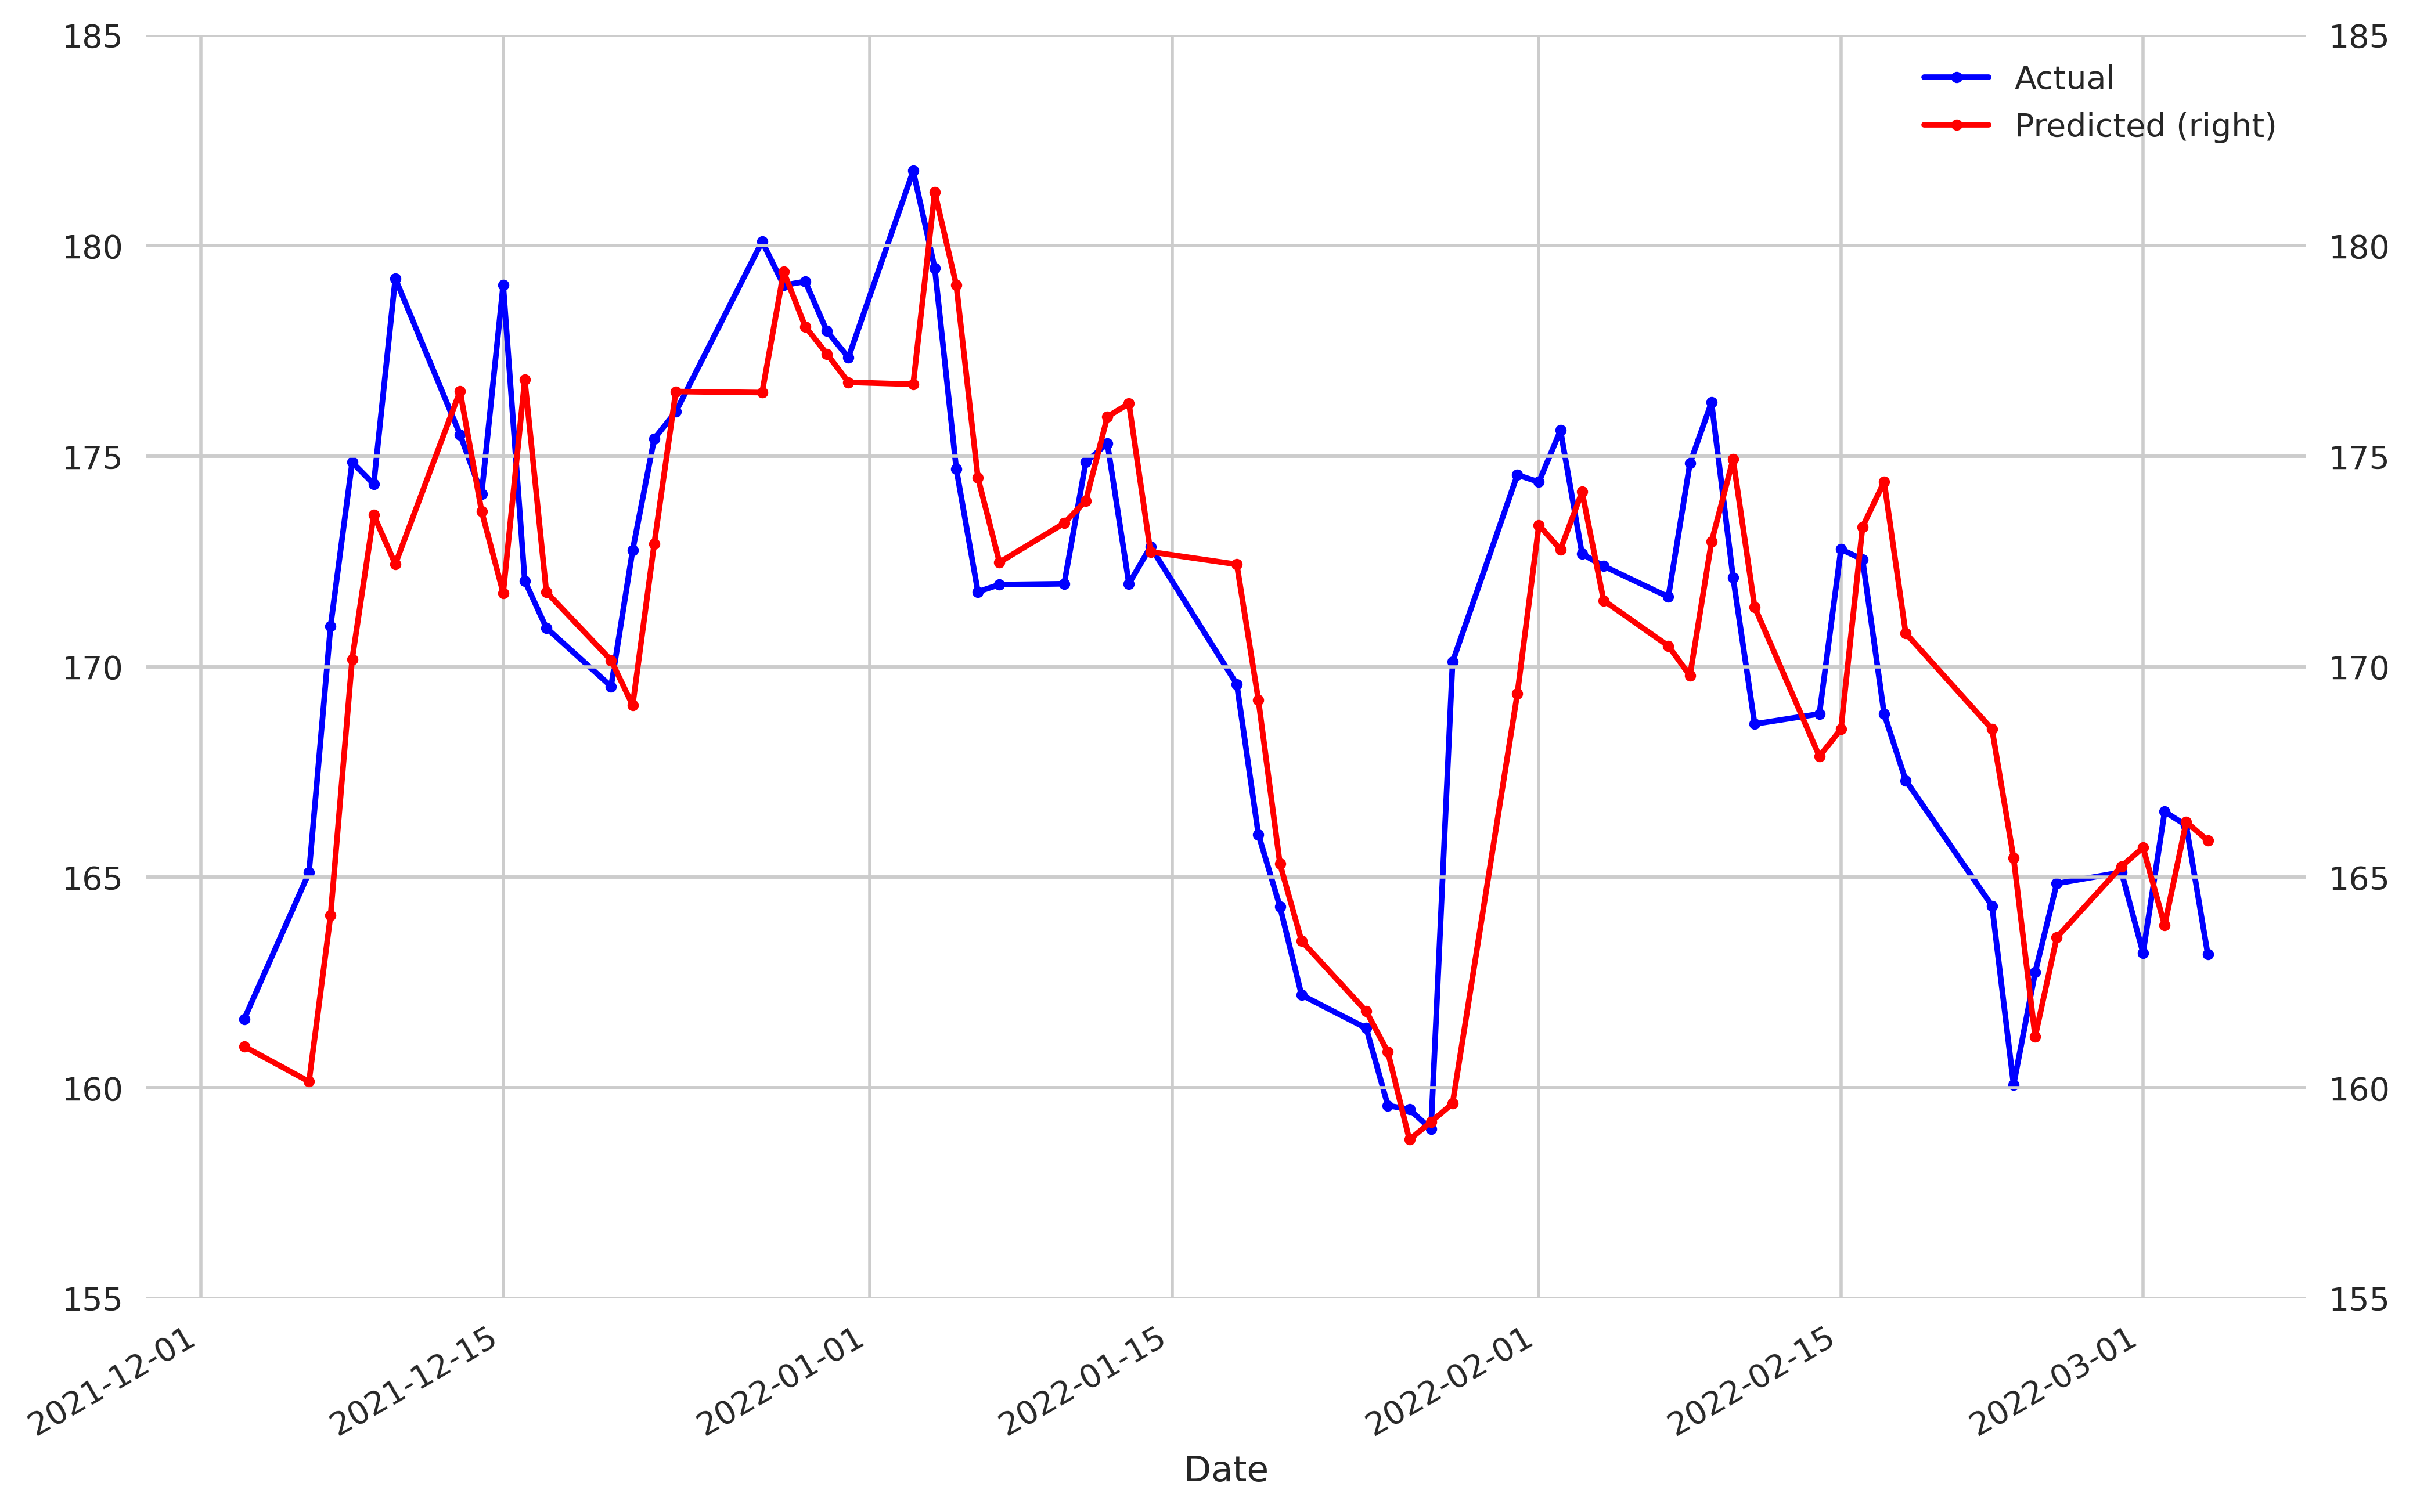

<IPython.core.display.Javascript object>

In [61]:
plt.figure(figsize=(12,8))

ax1 = df_compare["5. adjusted close"][-63:].plot(color='blue', grid=True, secondary_y=False, label='Actual', marker='.')
ax2 = df_compare["preds"][-63:].plot(color='red', grid=True, secondary_y=True, label='Predicted', marker='.')

a, b = 155, 185

ax1.set_ylim(a,b)
ax2.set_ylim(a,b)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_xlabel("Date")
plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [62]:
df_compare["actual_percentage_change"] = df_compare['5. adjusted close'].pct_change()
df_compare["actual_increase"] = df_compare["actual_percentage_change"].apply(lambda x: 1 if x > 0 else 0)

<IPython.core.display.Javascript object>

In [63]:
df_compare["predicted_percentage_change"] = df_compare['preds'].pct_change()
df_compare["predicted_increase"] = df_compare["predicted_percentage_change"].apply(lambda x: 1 if x > 0 else 0)

<IPython.core.display.Javascript object>

In [64]:
df_compare.fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [65]:
df_compare

,5. adjusted close,2. high,3. low,6. volume,returns,log_returns,preds,actual_percentage_change,actual_increase,predicted_percentage_change,predicted_increase
date,,,,,,,,,,,
2021-03-18,119.818452,123.18,120.320,121469755.0,-0.033905,-0.034493,123.140862,0.000000,0,0.000000,0
2021-03-19,119.281640,121.43,119.675,185549522.0,-0.004480,-0.004490,119.387184,-0.004480,0,-0.030483,0
2021-03-22,122.661568,123.87,120.260,111912284.0,0.028336,0.027942,118.616837,0.028336,1,-0.006453,0
2021-03-23,121.816586,124.24,122.140,95467142.0,-0.006889,-0.006913,122.198586,-0.006889,0,0.030196,1
2021-03-24,119.381049,122.90,120.065,88530485.0,-0.019993,-0.020196,122.637520,-0.019993,0,0.003592,1
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,165.120000,165.42,162.430,95056629.0,0.001638,0.001637,165.258850,0.001638,1,0.010323,1
2022-03-01,163.200000,166.60,161.970,83474425.0,-0.011628,-0.011696,165.705261,-0.011628,0,0.002701,1
2022-03-02,166.560000,167.36,162.950,79724750.0,0.020588,0.020379,163.857574,0.020588,1,-0.011150,0


<IPython.core.display.Javascript object>

In [66]:
df_compare = df_compare.drop("2021-03-18")


<IPython.core.display.Javascript object>

### Postive Increase Prediction %

In [67]:
df_compare[(df_compare["actual_increase"]==1) & (df_compare["predicted_increase"]==1)].shape[0] / df_compare[(df_compare["actual_increase"]==1)].shape[0]

0.5546875

<IPython.core.display.Javascript object>

### Negative Increase Prediction %

In [68]:
df_compare[(df_compare["actual_increase"]==0) & (df_compare["predicted_increase"]==0)].shape[0] / df_compare[(df_compare["actual_increase"]==0)].shape[0]

0.5043478260869565

<IPython.core.display.Javascript object>

### Overall Prediction Accuracy %

In [69]:
df_compare[(df_compare["actual_increase"] == df_compare["predicted_increase"])].shape[0] / (df_compare.shape[0])

0.5308641975308642

<IPython.core.display.Javascript object>

### Actual Distribution of Increase (1) vs. Decrease (0)

In [70]:
df_compare["actual_increase"].value_counts(normalize=True)

1    0.526749
0    0.473251
Name: actual_increase, dtype: float64

<IPython.core.display.Javascript object>